In [ ]:
from autoscalingsim import simulator
import pandas as pd

starting_time = pd.Timestamp("2020-09-17T10:00:00")
simulation_step = pd.Timedelta(10, unit = 'ms')
time_to_simulate_days = 0.0005#0.005
config_dir = "experiments/test"
results_dir = None

simulator = simulator.Simulator(simulation_step,
                                starting_time,
                                time_to_simulate_days)

simulator.add_simulation(config_dir,
                         results_dir)

simulator.start_simulation()

 23%|██████████████████                                                            | 1001/4320 [00:44<02:34, 21.52it/s]

[2020-11-11 20:23:36.607803] Left to simulate: 0 days 00:00:33.200000 min or 3320 steps


 46%|████████████████████████████████████▏                                         | 2003/4320 [01:33<02:09, 17.91it/s]

[2020-11-11 20:24:25.217951] Left to simulate: 0 days 00:00:23.200000 min or 2320 steps


 66%|███████████████████████████████████████████████████▊                          | 2867/4320 [02:15<01:06, 21.84it/s]

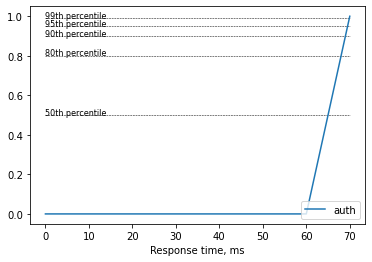

<Figure size 432x288 with 0 Axes>

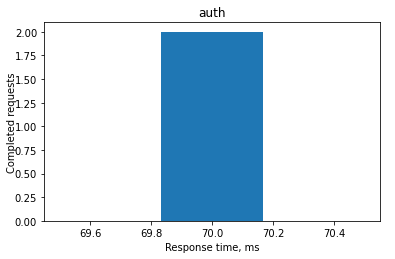

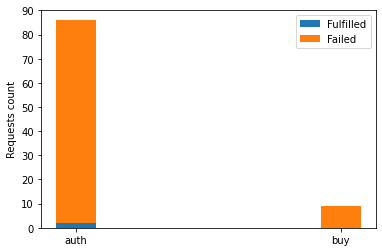

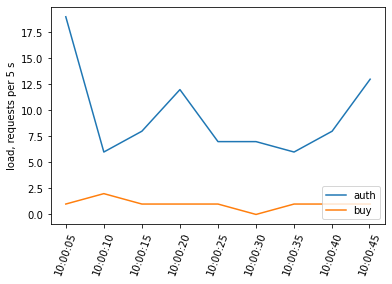

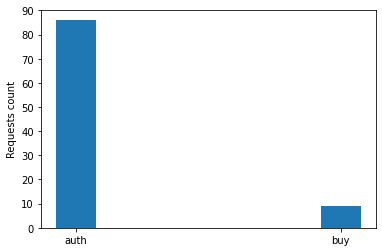

<Figure size 432x288 with 0 Axes>

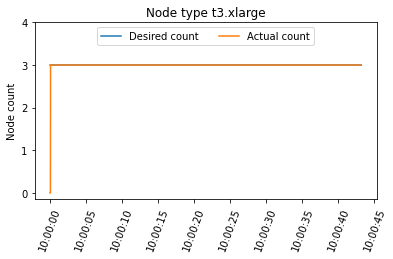

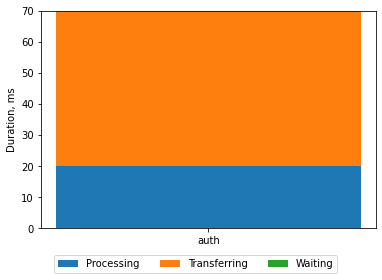

In [2]:
from autoscalingsim.analysis.analytical_engine import AnalysisFramework

af = AnalysisFramework(simulation_step, 'D:/AutoscalingSim/results/test')
af.build_figures(simulator.simulations['test'], '')

In [20]:
import pandas as pd

d1 = pd.DataFrame({'datetime': [pd.Timestamp(100), pd.Timestamp(200)], 'value': [1, 2]}).set_index('datetime')
d2 = pd.DataFrame({'datetime': [pd.Timestamp(100), pd.Timestamp(300)], 'value': [1, 4]}).set_index('datetime')


d2 = d2.reindex(d1.index.union(d2.index), fill_value = 0)
d1 = d1.reindex(d2.index.union(d1.index), fill_value = 0)

d = d1 + d2
d /= 4
d[d.index >= (max(d.index) - pd.Timedelta(100))]

,value
datetime,
1970-01-01 00:00:00.000000200,0.5
1970-01-01 00:00:00.000000300,1.0
